<a href="https://colab.research.google.com/github/DucTran182/Embryo_Classification/blob/main/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.3  # Split the data into 80% train and 20% validation
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/CV Group_Image Classifier/filtered_data/D5',
    target_size=(224, 224),  # VGG model requires 224x224 input size
    batch_size=32,
    class_mode='binary',  # Binary classification: Good or NotGood
    subset='training'  # Use training subset for training
)

validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/CV Group_Image Classifier/filtered_data/D5',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Use validation subset for validation
)

Found 346 images belonging to 2 classes.
Found 146 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [ ]:
# Adopt pre-trained VGG16
vgg_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

80134624/80134624 [==============================] - 5s 0us/step


In [ ]:
# Build model
model = Sequential()
model.add(vgg_base)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(64, input_dim=8, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))  # Binary classification, so use 'sigmoid'

vgg_base.trainable = False  # Freeze VGG layers

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 512)         2048      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [ ]:
# Train the model
hist = model.fit(train_generator, validation_data=validation_generator, epochs=20, batch_size=32)

Epoch 1/20
11/11 [==============================] - 152s 13s/step - loss: 1.5276 - accuracy: 0.8555 - val_loss: 1.7923 - val_accuracy: 0.6712
Epoch 2/20
11/11 [==============================] - 3s 236ms/step - loss: 1.1126 - accuracy: 0.9740 - val_loss: 1.8138 - val_accuracy: 0.6507
Epoch 3/20
11/11 [==============================] - 3s 227ms/step - loss: 0.9209 - accuracy: 1.0000 - val_loss: 1.5265 - val_accuracy: 0.6438
Epoch 4/20
11/11 [==============================] - 3s 230ms/step - loss: 0.7489 - accuracy: 1.0000 - val_loss: 1.2652 - val_accuracy: 0.6849
Epoch 5/20
11/11 [==============================] - 3s 238ms/step - loss: 0.6087 - accuracy: 1.0000 - val_loss: 1.1544 - val_accuracy: 0.6849
Epoch 6/20
11/11 [==============================] - 3s 229ms/step - loss: 0.4866 - accuracy: 1.0000 - val_loss: 1.0338 - val_accuracy: 0.6918
Epoch 7/20
11/11 [==============================] - 3s 230ms/step - loss: 0.3963 - accuracy: 1.0000 - val_loss: 0.9547 - val_accuracy: 0.6986
Epoch 

In [ ]:
import matplotlib.pyplot as plt

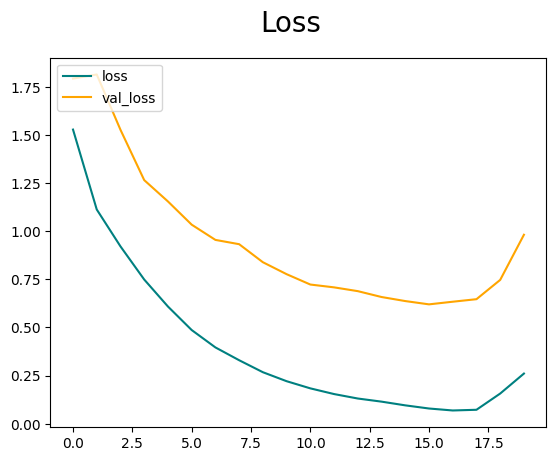

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

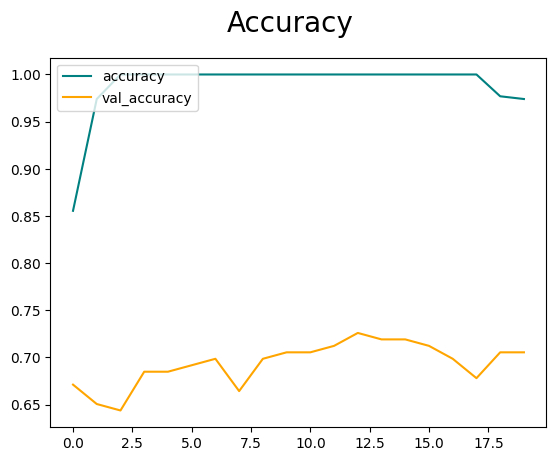

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
test_data_dir = '/content/drive/MyDrive/CV Group_Image Classifier/test_data/'


In [ ]:
# Load and preprocess the test data
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,  # No class labels for test data
    shuffle=False  # Maintain the order of test data
)

Found 60 images belonging to 1 classes.


In [ ]:
import pandas as pd

In [ ]:
# Create an empty DataFrame to store the predictions
predictions_df = pd.DataFrame(columns=['Image', 'Prediction'])

In [ ]:
import numpy as np

# Predict labels
predictions = model.predict(test_generator)

# Apply the threshold to all predictions in the array
threshold = 0.5
predicted_class = (predictions > threshold).astype(int)

# Store the image filename, prediction, and ground truth label in the DataFrame
for i in range(len(test_generator.filenames)):
    image = test_generator.filenames[i]
    true_label = 1 if "Good" in image else 0
    predictions_df = predictions_df.append({'Image': image, 'Prediction': predicted_class[i], 'True_Label': true_label}, ignore_index=True)

# Debugging the issue
try:
    correct_predictions = (predictions_df['Prediction'] == predictions_df['True_Label']).sum()
    total_predictions = len(predictions_df)
    accuracy_percentage = (correct_predictions / total_predictions) * 100
except Exception as e:
    print("An error occurred:", e)

print(f'Prediction Accuracy: {accuracy_percentage:.2f}%')

2/2 [==============================] - 25s 25s/step
Prediction Accuracy: 71.67%


<ipython-input-16-ef54e96fa3b1>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'Image': image, 'Prediction': predicted_class[i], 'True_Label': true_label}, ignore_index=True)
<ipython-input-16-ef54e96fa3b1>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'Image': image, 'Prediction': predicted_class[i], 'True_Label': true_label}, ignore_index=True)
<ipython-input-16-ef54e96fa3b1>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'Image': image, 'Prediction': predicted_class[i], 'True_Label': true_label}, ignore_index=True)
<ipython-input-16-ef54e96fa3b1>:14: FutureWarning: The frame.append method is d

In [ ]:
# Save the predictions DataFrame to a CSV file
file_path = '/content/drive/MyDrive/CV Group_Image Classifier/VGG19_D5_predictions.csv'
predictions_df.to_csv(file_path, index=False)
